In [8]:
import numpy as np
from collections import defaultdict
data_path = './ratings.dat'
n_users = 6040
n_movies = 3706

def load_rating_data(data_path, n_users, n_movies):
    data = np.zeros([n_users, n_movies], dtype=np.float32)
    movie_id_mapping = {}
    movie_n_rating = defaultdict(int)
    with open(data_path, 'r') as file:
        for line in file.readlines()[1:]:
            user_id, movie_id, rating, _ = line.split("::")
            user_id = int(user_id) - 1
            if movie_id not in movie_id_mapping:
                movie_id_mapping[movie_id] = len(movie_id_mapping)
            rating = int(rating)
            data[user_id, movie_id_mapping[movie_id]] = rating
            if rating > 0:
                movie_n_rating[movie_id] += 1
    return data, movie_n_rating, movie_id_mapping

data, movie_n_rating, movie_id_mapping = load_rating_data(data_path, n_users, n_movies)

def display_distribution(data):
    values, counts = np.unique(data, return_counts=True)
    for value, count in zip(values, counts):
        print(f'Number of rating {int(value)}: {count}')

display_distribution(data)

Number of rating 0: 21384032
Number of rating 1: 56174
Number of rating 2: 107557
Number of rating 3: 261197
Number of rating 4: 348971
Number of rating 5: 226309


In [9]:
movie_id_most, n_rating_most = sorted(movie_n_rating.items(), key=lambda d: d[1], reverse=True)[0]

print(f'Movie ID {movie_id_most} has {n_rating_most} ratings.')

Movie ID 2858 has 3428 ratings.


In [32]:
X_raw = np.delete(data, movie_id_mapping[movie_id_most], axis=1)
Y_raw = data[:, movie_id_mapping[movie_id_most]]
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

Shape of X: (3428, 3705)
Shape of Y: (3428,)


In [33]:
display_distribution(Y)

Number of rating 1: 83
Number of rating 2: 134
Number of rating 3: 358
Number of rating 4: 890
Number of rating 5: 1963


In [34]:
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1
n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()
print(f'{n_pos} positive samples and {n_neg} negative samples.')

2853 positive samples and 575 negative samples.


In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(len(Y_train), len(Y_test))

2742 686


In [37]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)
prediction_prob = clf.predict_proba(X_test)
print(prediction_prob[0:10])

[[7.50487439e-23 1.00000000e+00]
 [1.01806208e-01 8.98193792e-01]
 [3.57740570e-10 1.00000000e+00]
 [1.00000000e+00 2.94095407e-16]
 [1.00000000e+00 2.49760836e-25]
 [7.62630220e-01 2.37369780e-01]
 [3.47479627e-05 9.99965252e-01]
 [2.66075292e-11 1.00000000e+00]
 [5.88493563e-10 9.99999999e-01]
 [9.71326867e-09 9.99999990e-01]]


In [38]:
prediction = clf.predict(X_test)
print(prediction[:10])

[1. 1. 1. 0. 0. 0. 1. 1. 1. 1.]


In [39]:
accuracy = clf.score(X_test, Y_test)
print(f'The accuracy is: {accuracy*100:.1f}%')

The accuracy is: 71.6%


In [40]:
# 성능 테스트
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, prediction, labels=[0,1]))

[[ 60  47]
 [148 431]]


In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(Y_test, prediction, pos_label=1)

0.9016736401673641

In [42]:
recall_score(Y_test, prediction, pos_label=1)

0.7443868739205527

In [43]:
f1_score(Y_test, prediction, pos_label=1)

0.815515610217597

In [44]:
f1_score(Y_test, prediction, pos_label=0)

0.38095238095238093

In [45]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

         0.0       0.29      0.56      0.38       107
         1.0       0.90      0.74      0.82       579

    accuracy                           0.72       686
   macro avg       0.60      0.65      0.60       686
weighted avg       0.81      0.72      0.75       686



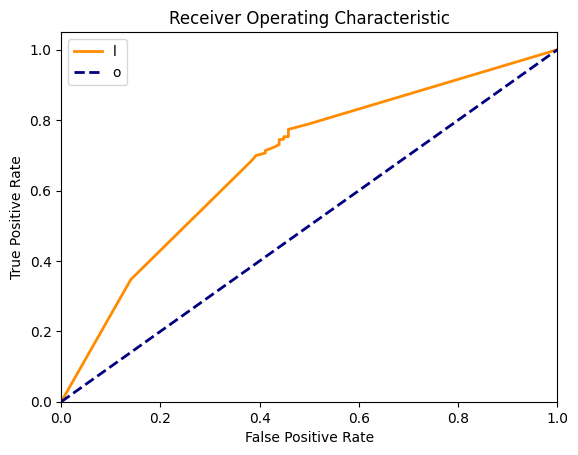

In [54]:
pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.1, 0.05)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            if y == 1:
                true_pos[i] += 1
            else:
                false_pos[i] += 1
        else:
            break

n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()
true_pos_rate = [tp / n_pos_test for tp in true_pos]
false_pos_rate = [fp / n_neg_test for fp in false_pos]

import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend("lower right")
plt.show()